# Project 2 - CutMix, Mixup 비교 실험

In [63]:
# 라이브러리 버전 확인

import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.6.0
1.21.4


In [64]:
# 데이터셋 다운로드
import tensorflow_datasets as tfds

(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
    data_dir='../tensorflow_datasets'
)

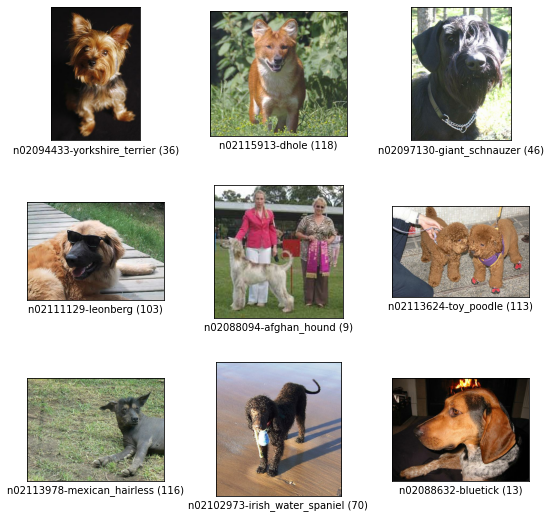

Figure(648x648)


In [65]:
# 다운받은 데이터셋 확인해보기

print(tfds.show_examples(ds_train, ds_info))

### CutMix

In [66]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    

    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

In [67]:
# 바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현해 봅시다.

# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

In [68]:
def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = int((image_size_x*image_size_y))
        
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [69]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### Mixup

In [70]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

In [71]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

In [72]:
# Augmentation을 적용한 데이터셋 만들기
# CutMix or Mixup augmentation을 적용하기

def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def onehot(image, label):
    label = tf.one_hot(label, num_classes)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    
    
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
        
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
        
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    
    return ds



### 데이터에 전처리를 적용해보자

In [73]:
num_classes = ds_info.features["label"].num_classes

In [74]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

In [75]:
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)

In [76]:
ds_train_cutmix = apply_normalize_on_dataset(ds_train, batch_size=16, with_aug=True, with_cutmix=True)

In [77]:
ds_train_mixup = apply_normalize_on_dataset(ds_train, batch_size=16, with_aug=True, with_mixup=True)

In [78]:
# 테스트 데이터셋 생성

ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

### 전처리 적용된 데이터 확인하기

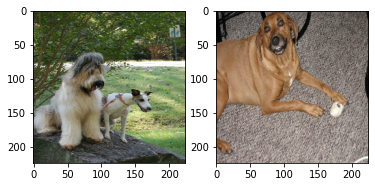

In [99]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

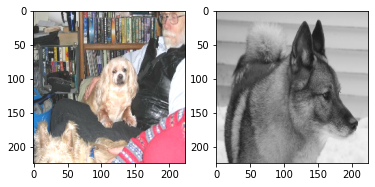

In [80]:
for i, (image, label) in enumerate(ds_train_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

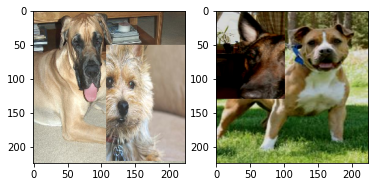

In [101]:
for i, (image, label) in enumerate(ds_train_cutmix.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

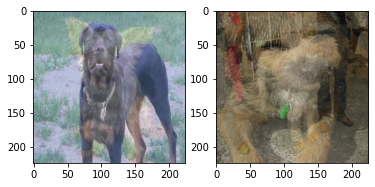

In [83]:
for i, (image, label) in enumerate(ds_train_mixup.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

### 모델 만들기

In [103]:
(num_classes)

120

In [105]:
# 전처리 하지않은 모델

from tensorflow import keras

resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 0s 0us/step


In [106]:
# aug를 적용한 모델

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [107]:
# cutmix를 적용한 모델

cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [108]:
# mixup을 적용한 모델

# qugmentation으로 학습할 모델 추가
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [109]:
resnet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dense (Dense)                (None, 120)               245880    
Total params: 23,833,592
Trainable params: 23,780,472
Non-trainable params: 53,120
_________________________________________________________________


### 사용할 모델 compile

In [111]:
EPOCH = 10
batch_size = 16

In [113]:
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [114]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [115]:
cutmix_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

In [116]:
mixup_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy'],
)

### 모델 학습 진행

In [117]:
no_aug_resnet50_history = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 158s 201ms/step - loss: 1.5224 - accuracy: 0.6004 - val_loss: 1.9307 - val_accuracy: 0.4664
Epoch 2/10
750/750 [==============================] - 151s 201ms/step - loss: 0.5767 - accuracy: 0.8487 - val_loss: 1.0328 - val_accuracy: 0.6953
Epoch 3/10
750/750 [==============================] - 151s 201ms/step - loss: 0.1711 - accuracy: 0.9697 - val_loss: 0.9553 - val_accuracy: 0.7259
Epoch 4/10
750/750 [==============================] - 151s 201ms/step - loss: 0.0502 - accuracy: 0.9957 - val_loss: 0.9059 - val_accuracy: 0.7410
Epoch 5/10
750/750 [==============================] - 151s 201ms/step - loss: 0.0238 - accuracy: 0.9987 - val_loss: 0.9260 - val_accuracy: 0.7427
Epoch 6/10
750/750 [==============================] - 166s 222ms/step - loss: 0.0176 - accuracy: 0.9994 - val_loss: 0.9369 - val_accuracy: 0.7418
Epoch 7/10
750/750 [==============================] - 151s 201ms/step - loss: 0.0131 - accuracy: 0.9992 - val_loss: 0.9408 -

In [118]:
del resnet50

In [119]:
aug_resnet50_history = aug_resnet50.fit(
    ds_train_aug, # augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 159s 202ms/step - loss: 2.2503 - accuracy: 0.4307 - val_loss: 3.1017 - val_accuracy: 0.2484
Epoch 2/10
750/750 [==============================] - 151s 201ms/step - loss: 0.9642 - accuracy: 0.7261 - val_loss: 1.2185 - val_accuracy: 0.6449
Epoch 3/10
750/750 [==============================] - 151s 201ms/step - loss: 0.5104 - accuracy: 0.8608 - val_loss: 1.0756 - val_accuracy: 0.6866
Epoch 4/10
750/750 [==============================] - 150s 201ms/step - loss: 0.2696 - accuracy: 0.9332 - val_loss: 1.0738 - val_accuracy: 0.6927
Epoch 5/10
750/750 [==============================] - 151s 201ms/step - loss: 0.1440 - accuracy: 0.9719 - val_loss: 1.0137 - val_accuracy: 0.7161
Epoch 6/10
750/750 [==============================] - 151s 201ms/step - loss: 0.0854 - accuracy: 0.9869 - val_loss: 1.0381 - val_accuracy: 0.7022
Epoch 7/10
750/750 [==============================] - 151s 201ms/step - loss: 0.0537 - accuracy: 0.9926 - val_loss: 0.9522 -

In [120]:
del aug_resnet50

In [121]:
cutmix_resnet50_history = cutmix_resnet50.fit(
    ds_train_cutmix, # Cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['test'].num_examples/batch_size),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 161s 204ms/step - loss: 3.8622 - accuracy: 0.2060 - val_loss: 3.0637 - val_accuracy: 0.2590
Epoch 2/10
750/750 [==============================] - 152s 202ms/step - loss: 3.0349 - accuracy: 0.4069 - val_loss: 1.3922 - val_accuracy: 0.6178
Epoch 3/10
750/750 [==============================] - 152s 202ms/step - loss: 2.7300 - accuracy: 0.4960 - val_loss: 1.3862 - val_accuracy: 0.6168
Epoch 4/10
750/750 [==============================] - 152s 202ms/step - loss: 2.5523 - accuracy: 0.5547 - val_loss: 1.2249 - val_accuracy: 0.6460
Epoch 5/10
750/750 [==============================] - 152s 202ms/step - loss: 2.4317 - accuracy: 0.5871 - val_loss: 1.2616 - val_accuracy: 0.6621
Epoch 6/10
750/750 [==============================] - 151s 202ms/step - loss: 2.3151 - accuracy: 0.6266 - val_loss: 1.0844 - val_accuracy: 0.7003
Epoch 7/10
750/750 [==============================] - 167s 223ms/step - loss: 2.2225 - accuracy: 0.6566 - val_loss: 1.1350 -

In [122]:
del cutmix_resnet50

In [123]:
mixup_resnet50_history = mixup_resnet50.fit(
    ds_train_mixup, # mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 160s 202ms/step - loss: 3.7874 - accuracy: 0.2281 - val_loss: 3.9447 - val_accuracy: 0.1336
Epoch 2/10
750/750 [==============================] - 152s 202ms/step - loss: 2.9236 - accuracy: 0.4469 - val_loss: 1.6968 - val_accuracy: 0.5356
Epoch 3/10
750/750 [==============================] - 152s 203ms/step - loss: 2.6707 - accuracy: 0.5444 - val_loss: 1.5169 - val_accuracy: 0.5768
Epoch 4/10
750/750 [==============================] - 152s 203ms/step - loss: 2.5031 - accuracy: 0.6132 - val_loss: 1.3943 - val_accuracy: 0.6194
Epoch 5/10
750/750 [==============================] - 152s 202ms/step - loss: 2.3722 - accuracy: 0.6565 - val_loss: 1.2246 - val_accuracy: 0.6574
Epoch 6/10
750/750 [==============================] - 152s 203ms/step - loss: 2.2984 - accuracy: 0.6873 - val_loss: 1.2050 - val_accuracy: 0.6659
Epoch 7/10
750/750 [==============================] - 152s 203ms/step - loss: 2.2239 - accuracy: 0.7085 - val_loss: 1.2326 -

In [124]:
del mixup_resnet50

### 결과화면 그래프로 그려보기

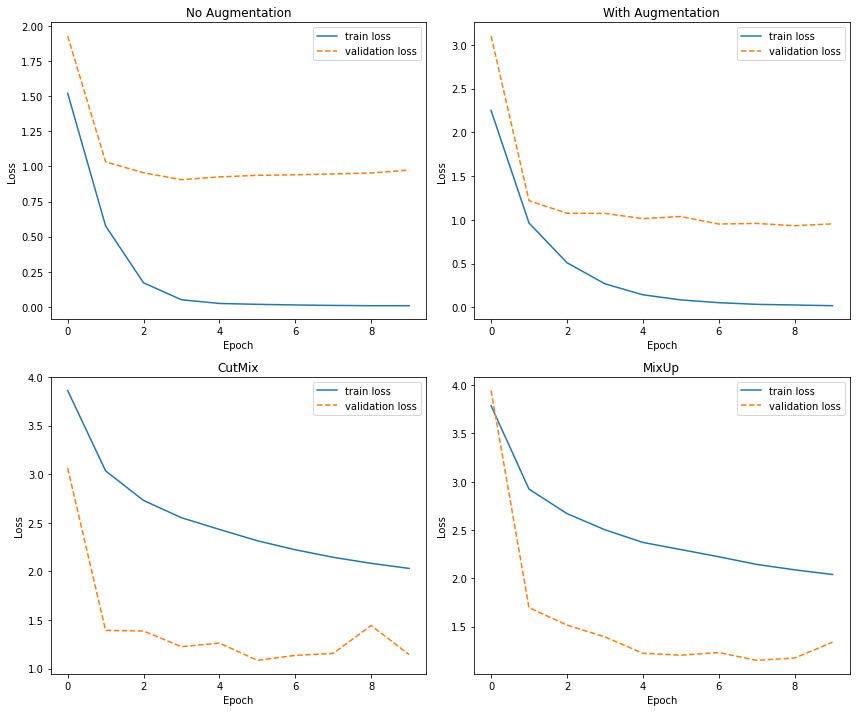

In [128]:
import matplotlib.pyplot as plt

# Loss and val_loss from each history
losses = [no_aug_resnet50_history.history['loss'],
          aug_resnet50_history.history['loss'],
          cutmix_resnet50_history.history['loss'],
          mixup_resnet50_history.history['loss']]

val_losses = [no_aug_resnet50_history.history['val_loss'],
              aug_resnet50_history.history['val_loss'],
              cutmix_resnet50_history.history['val_loss'],
              mixup_resnet50_history.history['val_loss']]

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Labels for different training settings
labels = ['No Augmentation', 'With Augmentation', 'CutMix', 'MixUp']

# Plot loss for each setting
for i, ax in enumerate(axes.flat):
    ax.plot(losses[i], label='train loss')
    ax.plot(val_losses[i], '--', label='validation loss')
    ax.set_title(labels[i])
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(loc='upper right')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

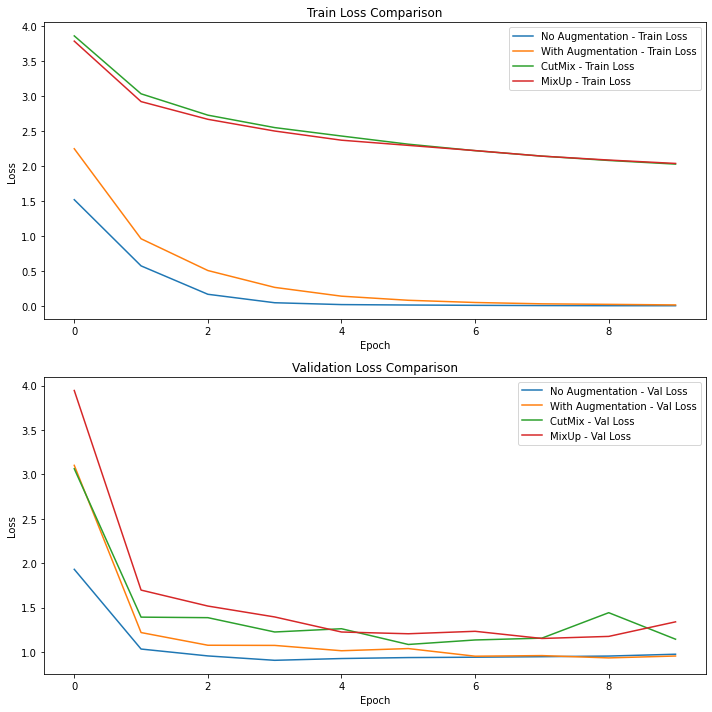

In [133]:
import matplotlib.pyplot as plt

# Histories for different augmentation settings
histories = [no_aug_resnet50_history, aug_resnet50_history, cutmix_resnet50_history, mixup_resnet50_history]

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Labels for different training settings
labels = ['No Augmentation', 'With Augmentation', 'CutMix', 'MixUp']

# Plot train loss for each setting
for history, label in zip(histories, labels):
    axes[0].plot(history.history['loss'], label=f'{label} - Train Loss')

# Plot val_loss for each setting
for history, label in zip(histories, labels):
    axes[1].plot(history.history['val_loss'], label=f'{label} - Val Loss')

# Set titles and labels for the subplots
axes[0].set_title('Train Loss Comparison')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()

axes[1].set_title('Validation Loss Comparison')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


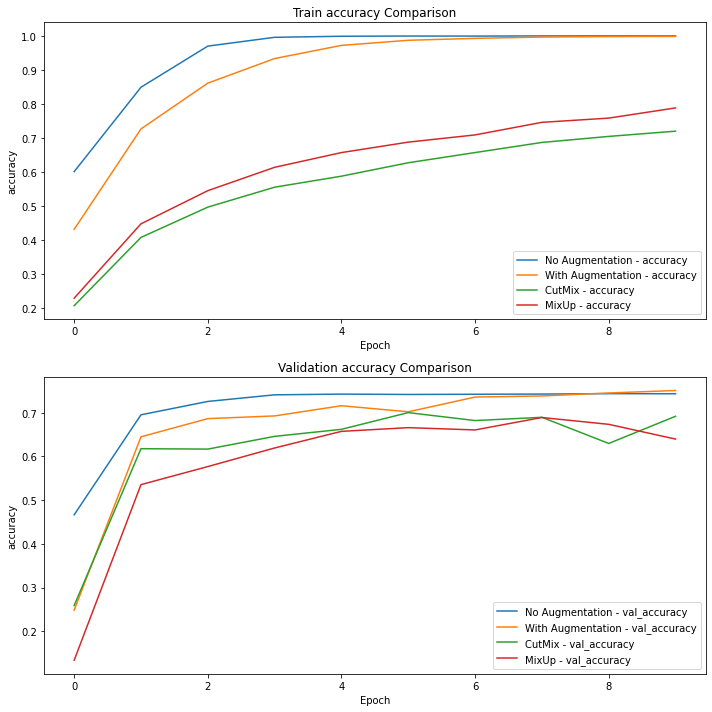

In [135]:
import matplotlib.pyplot as plt

# Histories for different augmentation settings
histories = [no_aug_resnet50_history, aug_resnet50_history, cutmix_resnet50_history, mixup_resnet50_history]

# Create a figure with two subplots
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

# Labels for different training settings
labels = ['No Augmentation', 'With Augmentation', 'CutMix', 'MixUp']

# Plot train loss for each setting
for history, label in zip(histories, labels):
    axes[0].plot(history.history['accuracy'], label=f'{label} - accuracy')

# Plot val_loss for each setting
for history, label in zip(histories, labels):
    axes[1].plot(history.history['val_accuracy'], label=f'{label} - val_accuracy')

# Set titles and labels for the subplots
axes[0].set_title('Train accuracy Comparison')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('accuracy')
axes[0].legend()

axes[1].set_title('Validation accuracy Comparison')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('accuracy')
axes[1].legend()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


### 각 Augmentation 기법을 적용하고, 그에 따른 성능 비교 분석 및 문제점

- cutmix, mixup은 no_aug, aug와는 다르게 train loss가 validation loss보다 높게 나타났다.
- 그리고 4가지 모델의 validation loss는 cutmix, mixup이 살짝 높긴 하지만 전체적으로 비슷한 경향을 나타내었다.
- 이는 이미지를 섞어서 학습을 시켜도 정제가 되어있지 않은 validation dataset에 대해 좋은 성능을 나타낸다는 것을 의미한다.

---

- CutMix, MixUp은 학습 데이터를 혼합하여 모델이 더 일반회된 특성을 학습하도록 도와준다.
- 학습중에 모델은 더 다양한 입력 형태와 패턴을 다루게 되는데, 이로 인해 모델이 복잡한 문제에 대처하려고 노력하게 된다.
- 따라서 train 데이터셋에서 cutmix, mixup 방법을 통한 데이터 증강은 모델이 더 어려운 학습 과정을 겪게 하므로 일반적으로 아무런 데이터 증강을 적용하지 않은 원본이미지로 구성된 validation loss보다  train loss가 더 높게 나타난다.